# week 09: seq2seq practice

## Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [6]:
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/e94d3f464e805824663c34f596e23c44194ed40c/06_wordvectors_rnn/names.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
!curl -O https://raw.githubusercontent.com/v-goncharenko/madmo-adv/e94d3f464e805824663c34f596e23c44194ed40c/06_wordvectors_rnn/names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 55868  100 55868    0     0   376k      0 --:--:-- --:--:-- --:--:--  458k


In [8]:
START_TOKEN, PAD_TOKEN = "_", " "

In [9]:
def read_names(filename: str, start_token: str = START_TOKEN):
    with open(filename) as file:
        return [start_token + line.strip() for line in file]

In [10]:
names = read_names("names.txt")

Token – "atomic" element of the sequence

In [11]:
print(f"n samples = {len(names)}\n")

for name in names[::1000]:
    print(name)

n samples = 7944

_Abagael
_Claresta
_Glory
_Liliane
_Prissie
_Geeta
_Giovanne
_Piggy


max length = 16


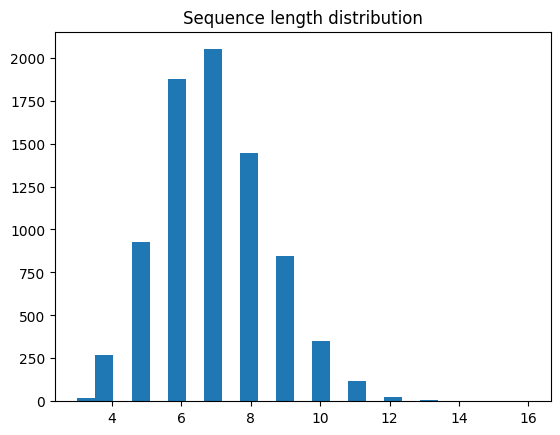

In [12]:
lengths = list(map(len, names))
MAX_LENGTH = max(lengths)
print(f"max length = {MAX_LENGTH}")

plt.title("Sequence length distribution")
plt.hist(lengths, bins=25)
plt.show()

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [13]:
tokens_set = set()

for name in names:
    tokens_set.update(name)

tokens = sorted(tokens_set)  # list of all unique characters in the dataset

num_tokens = len(tokens)
print(f"num_tokens = {num_tokens}")

num_tokens = 56


### Convert characters to integers

Torch is built for crunching numbers, not strings.
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [14]:
# dictionary of symbol -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [15]:
from typing import Optional, Sequence

In [16]:
def to_matrix(
    names: Sequence[str],
    max_len: Optional[int] = None,
    pad: int = token_to_id[PAD_TOKEN],
    dtype=np.int64,
    batch_first: bool = True,
):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, names))
    names_ix = np.full((len(names), max_len), pad, dtype)

    for i, name in enumerate(names):
        line_ix = [token_to_id[char] for char in name]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [17]:
# Example: cast 4 random names to matrices, pad with zeros
print("\n".join(names[::2000]))
print(to_matrix(names[::2000]))

_Abagael
_Glory
_Prissie
_Giovanne
[[29  3 31 30 36 30 34 41  0]
 [29  9 41 44 47 54  0  0  0]
 [29 18 47 38 48 48 38 34  0]
 [29  9 38 44 51 30 43 43 34]]


In [18]:
to_matrix(names).shape

(7944, 16)

# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.

![](https://github.com/girafe-ai/ml-mipt/raw/ab0cbd5d553e9da309bda54d35b4e93a8eb99696/week0_10_embeddings_and_seq2seq/rnn.png)

Since we're training a language model, there should also be:

* An embedding layer that converts character id x_t to a vector
* An output layer that predicts probabilities of next phoneme

In [20]:
import torch
import torch.nn.functional as F
from torch import nn

In [21]:
emb_test = nn.Embedding(num_tokens, 7)  # One hot + Linears

In [22]:
example_batch = torch.from_numpy(to_matrix([" Den", " Jhon"])).type(torch.int64)

In [23]:
example_batch

tensor([[ 0,  6, 34, 43,  0],
        [ 0, 12, 37, 44, 43]])

In [24]:
example_batch.shape

torch.Size([2, 5])

In [25]:
# batch size, seq length, emb dim
emb = emb_test(example_batch)
emb.shape

torch.Size([2, 5, 7])

In [26]:
emb

tensor([[[-0.0633, -0.0571,  0.6367,  0.6994, -1.3763, -1.9189, -1.3977],
         [ 0.7037,  0.7872,  0.3060,  0.8930,  1.0970,  1.1757, -0.4603],
         [ 0.9329, -0.2554,  0.6957, -1.4233,  3.0965, -0.2970, -0.3013],
         [ 0.0086, -0.1083, -0.7048,  0.0704,  0.6873, -1.1189,  1.0693],
         [-0.0633, -0.0571,  0.6367,  0.6994, -1.3763, -1.9189, -1.3977]],

        [[-0.0633, -0.0571,  0.6367,  0.6994, -1.3763, -1.9189, -1.3977],
         [ 2.0348, -1.3100,  0.5635, -1.7110, -0.4955,  0.0672, -0.7650],
         [-1.2650,  1.4805,  1.0491,  0.8753, -0.8012, -1.4639, -0.8180],
         [ 0.5745,  0.5661,  2.1495, -0.8978, -0.2380, -1.3021,  0.1335],
         [ 0.0086, -0.1083, -0.7048,  0.0704,  0.6873, -1.1189,  1.0693]]],
       grad_fn=<EmbeddingBackward0>)

In [27]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        # TODO: init with normal distribution and make it trainable
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [28]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [29]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

In [30]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

In [31]:
logp_seq.shape

torch.Size([5, 8, 56])

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [32]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to
# get its view of desired shape.

loss = criterion(
    predictions_logp.contiguous().view(-1, num_tokens),
    actual_next_tokens.contiguous().view(-1),
)

In [33]:
loss.backward()

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [34]:
from random import sample

from IPython.display import clear_output


char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

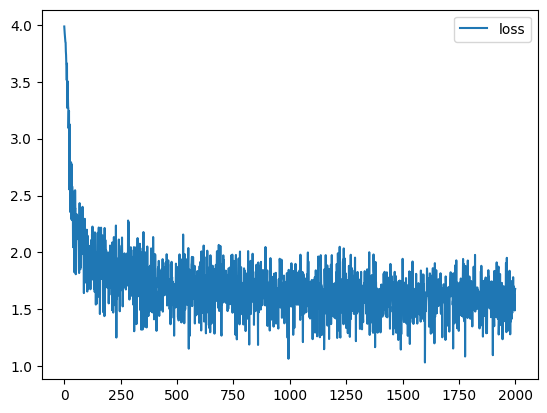

In [36]:
for i in range(1000):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    #TODO: accuracy computation
    # accuracy = (predictions_logp.argmax(dim=-1) == actual_next_tokens).float().mean()
    predicted_tokens = predictions_logp.argmax(dim=-1)  # Get the predicted token indices
    accuracy = (predicted_tokens == actual_next_tokens).float().mean()  # Compare with actual next tokens
    print(f"accuracy = {accuracy}")


    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff.
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [37]:
def generate_sample(char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [38]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase="_", temperature=1.0))

_Lulhy          
_Jeen           
_Merger         
_Grobellita     
_Gelestien      
_Cherler        
_Rediree        
_Bishelia       
_Imrel          
_Py             


In [39]:
"_Lellcy" in names

False

In [40]:
for _ in range(20):
    print(generate_sample(char_rnn, seed_phrase="_Al"))

_Albie          
_Allaquann      
_Aldie          
_Alina          
_AlometK        
_Allaed         
_Alley          
_Alin           
_Allene         
_Alveli         
_Aloullisa      
_Alibett        
_Alvina         
_Alyndy         
_Allleine       
_Aloneola       
_Allie          
_Alocell        
_Alvina         
_Albe           


In [41]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.01))

_Carista        
_Carista        
_Carista        
_Carista        
_Carista        
_Carista        
_Carista        
_Carista        
_Carista        
_Carista        


In [42]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=3.0))

_hGpuobeJkhetT A
_GomsiseacJuw h 
_DmaemnaQPWeSVvl
_RellsanneRAyy  
_twpyrydunml rif
_ivwzgotpiPu   _
_DyllhfunHoik  A
_NAolipf wPuza X
_CmrlrB iy      
_Zfybozasdokte o


In [47]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=1.0))

_Mibelly        
_Helly          
_Zewwy          
_Camave         
_Ammoly         
_Riverda        
_Mary           
_Londice        
_Crina          
_Dovy           


#### A bit strange generation

We use `PAD_TOKEN` instead of `START_TOKEN` as a starting point.

This is something our network haven't seen and thus don't expect.

In [48]:
for _ in range(10):
    print(generate_sample(char_rnn, PAD_TOKEN))

In [49]:
for _ in range(10):
    print(generate_sample(char_rnn, "_ "))

_ olbella       
_ ila           
_ ilel          
_ almeline      
_               
_               
_               
_               
_               
_ y             


### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion.

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def forward_char(self, x, h=None):
        if h is None:
            out, h = self.rnn(self.emb(x))
        else:
            out, h = self.rnn(self.emb(x), h)
        out = self.hid_to_logits(out)
        return out, h

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [ ]:
logp_seq = model(batch_ix)

loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, num_tokens), batch_ix[:, 1:].contiguous().view(-1)
)

loss.backward()

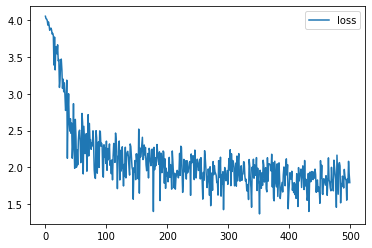

In [ ]:
for i in range(500):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [ ]:
def generate_sample_lstm(
    char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0, device=None
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    logits, h = char_rnn.forward_char(x_sequence)
    logits = logits[:, -1]

    # start generating
    for _ in range(max_length - x_sequence.shape[1] + 1):
        p_next = F.softmax(logits / temperature, dim=-1).cpu().data.numpy().squeeze()

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        logits, h = char_rnn.forward_char(next_ix, h)

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample_lstm(model, temperature=1.0))

_Gio             
_Arllna          
_Bad             
_Wteunir         
_Erlenla         
_Betde-          
_BLagh           
_Saneh           
_Amyn            
_Sbeunhee        


### To sum up:
- PyTorch is convenient both for prototyping and production
- There are a lot of pre-implemented methods/layers/activations out of the box
- It's much easier (*really easier*) to use PyTorch than TensorFlow on entry level.
- Neural networks are not *black boxes*, they are pretty nice and easy to use (almost always).

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__